# Proyek Klasifikasi Gambar: [Indonesian Wayang (Traditional Puppet Show)]
- **Nama:** [Lalu Olfata Vedora Zurji]
- **Email:** [mc253d5y1872@student.devacademy.id]
- **ID Dicoding:** [MC253D5Y1872]

## Import Semua Packages/Library yang Digunakan

In [1]:
# Library yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm as tq

In [2]:
# Libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

In [3]:
# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Preparation

### Data Loading

In [8]:
from google.colab import drive
drive.mount('/content/drive')

import zipfile

# Tentukan path file ZIP yang ada di Google Drive
local_zip = '/content/drive/MyDrive/labeled-indonesian-wayang-fixed.zip'  # Ganti dengan path file ZIP kamu

# Tentukan lokasi ekstraksi
extract_to = '/content/wayang/labeled-indonesian-wayang-fixed'

# Ekstrak file ZIP
with zipfile.ZipFile(local_zip, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Dataset berhasil diekstrak ke {extract_to}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset berhasil diekstrak ke /content/wayang/labeled-indonesian-wayang-fixed


In [9]:
# import shutil
# import os

# # Path folder bermasalah
# base_path = '/content/wayang/labeled-indonesian-wayang-fixed/labeled-indonesian-wayang-fixed'
# # Path folder yang seharusnya
# target_path = '/content/wayang/labeled-indonesian-wayang-fixed'

# # List semua subfolder di base_path
# subfolders = os.listdir(base_path)

# for subfolder in subfolders:
#     source = os.path.join(base_path, subfolder)
#     destination = os.path.join(target_path, subfolder)
#     shutil.move(source, destination)

# # Hapus folder kosong setelah dipindahkan
# os.rmdir(base_path)

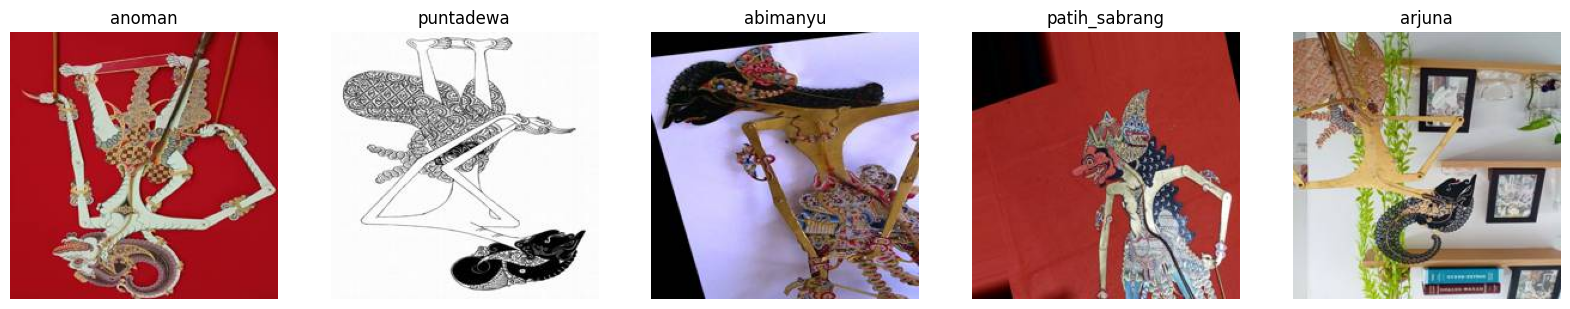

In [10]:
# Tentukan folder tempat dataset gambar diekstrak
dataset_dir = '/content/wayang/labeled-indonesian-wayang-fixed'  # Ganti dengan path ekstraksi datasetmu
# List folder (label) dalam dataset
labels = os.listdir(dataset_dir)

# Menampilkan beberapa gambar pertama dari dataset
fig, axes = plt.subplots(1, 5, figsize=(20, 20))

# Loop untuk menampilkan gambar dari 5 label pertama
for i, label in enumerate(labels[:5]):  # Menampilkan 5 label pertama
    label_path = os.path.join(dataset_dir, label)

    # Menyaring hanya file gambar, bukan folder
    image_files = [f for f in os.listdir(label_path) if f.endswith(('jpg', 'jpeg', 'png', 'bmp', 'gif'))]

    if image_files:  # Jika ada file gambar dalam folder
        img_path = os.path.join(label_path, image_files[0])  # Mengambil gambar pertama
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(label)

plt.show()

In [11]:
# Menghitung jumlah data per label
labels_list = []

# Menyusun daftar semua label berdasarkan gambar dalam folder
for label in labels:
    label_path = os.path.join(dataset_dir, label)
    image_files = [f for f in os.listdir(label_path) if f.endswith(('jpg', 'jpeg', 'png'))]
    labels_list.extend([label] * len(image_files))  # Menambahkan label sesuai jumlah gambar

# Menghitung jumlah data per label
label_counts = pd.Series(labels_list).value_counts()

# Menampilkan jumlah data per label dalam bentuk teks
print("Total Jumlah Label:", len(label_counts))
print("Persebaran Data per Label:")
print(label_counts)

Total Jumlah Label: 22
Persebaran Data per Label:
anoman           480
puntadewa        480
abimanyu         480
patih_sabrang    480
sengkuni         480
dursasana        480
togog            480
buta             480
bima             480
baladewa         480
durna            480
gareng           480
semar            480
karna            480
kresna           480
cakil            480
arjuna           479
petruk           479
bagong           479
duryudana        479
gatotkaca        479
nakula_sadewa    478
Name: count, dtype: int64


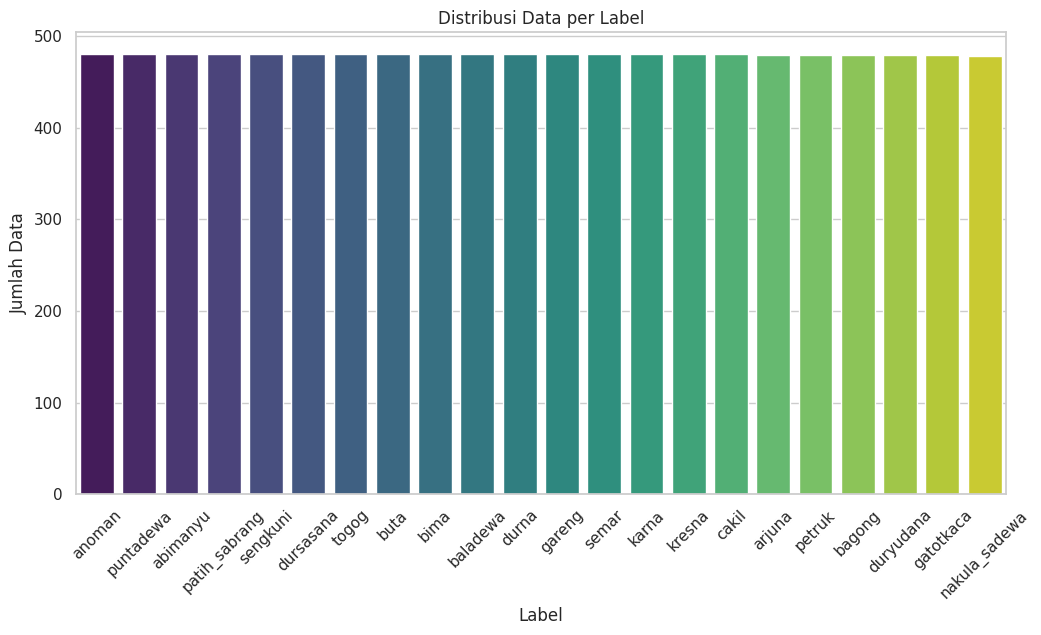

In [12]:
# Set seaborn style
sns.set(style="whitegrid")

# Plot distribusi data per label
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")

# Menambahkan label dan judul
plt.title("Distribusi Data per Label")
plt.xlabel("Label")
plt.ylabel("Jumlah Data")
plt.xticks(rotation=45)  # Rotasi label sumbu X 45 derajat

# Menampilkan plot
plt.show()

### Data Preprocessing

#### Resize dan Normalisasi

In [13]:
from tqdm import tqdm

def resize_and_save_images(source_dir, target_dir, target_size=(224, 224)):
    # Kalau folder target belum ada, buat
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    # Loop semua folder label
    labels = os.listdir(source_dir)
    for label in tqdm(labels, desc='Resizing folders'):
        label_path = os.path.join(source_dir, label)
        target_label_path = os.path.join(target_dir, label)

        if not os.path.exists(target_label_path):
            os.makedirs(target_label_path)

        if os.path.isdir(label_path):  # Pastikan itu folder, bukan file
            images = os.listdir(label_path)
            for image_file in tqdm(images, desc=f'Resizing {label}', leave=False):
                if image_file.lower().endswith(('jpg', 'jpeg', 'png', 'bmp', 'gif')):
                    img_path = os.path.join(label_path, image_file)
                    img = Image.open(img_path).convert('RGB')  # Convert supaya tidak error mode
                    img_resized = img.resize(target_size)

                    save_path = os.path.join(target_label_path, image_file)
                    img_resized.save(save_path)

# Example usage:
source_dataset_dir = '/content/wayang/labeled-indonesian-wayang-fixed'
target_dataset_dir = '/content/wayang/wayang-resized'  # Folder hasil resize

resize_and_save_images(source_dataset_dir, target_dataset_dir, target_size=(224, 224))

Resizing folders: 100%|██████████| 22/22 [00:09<00:00,  2.28it/s]


#### Data Augmentation

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Dataset hasil resize
dataset_fix = '/content/wayang/wayang-resized'

# Buat ImageDataGenerator + augmentasi + split
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 80% training, 20% validation
)

# Train Generator
train_generator = datagen.flow_from_directory(
    dataset_fix,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation Generator (augmentasi biasa hanya rescale)
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

val_generator = val_datagen.flow_from_directory(
    dataset_fix,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 8448 images belonging to 22 classes.
Found 2111 images belonging to 22 classes.


#### Split Dataset

In [15]:
# Buat 1 datagen untuk training dan validation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.4  # 30% dibagi validation + test
)

# Train generator (70% data)
train_generator = datagen.flow_from_directory(
    dataset_fix,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Untuk validation/test, buat datagen baru tanpa augmentasi
test_val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.5
)

# Validation generator (15% data)
val_generator = test_val_datagen.flow_from_directory(
    dataset_fix,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=42
)

# Test generator (ambil validation lagi dengan shuffle=False untuk evaluasi final)
test_generator = test_val_datagen.flow_from_directory(
    dataset_fix,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False  # Test set jangan di-shuffle
)


Found 6336 images belonging to 22 classes.
Found 5279 images belonging to 22 classes.
Found 5279 images belonging to 22 classes.


In [16]:
print(f"Jumlah data training: {train_generator.samples}")
print(f"Jumlah data validation: {val_generator.samples}")
print(f"Jumlah data test: {test_generator.samples}")

Jumlah data training: 6336
Jumlah data validation: 5279
Jumlah data test: 5279


## Modelling

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

# Inisialisasi model
model = Sequential()

# Layer Convolutional pertama
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer Convolutional kedua
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer Convolutional ketiga
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer Convolutional keempat
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Global Average Pooling
model.add(GlobalAveragePooling2D())

# Fully Connected Layer
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))  # Dropout untuk menghindari overfitting

# Output Layer
model.add(Dense(train_generator.num_classes, activation='softmax'))

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Ringkasan model
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 22)             │        22,550 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 674,134 (2.57 MB)

 Trainable params: 674,134 (2.57 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# EarlyStopping untuk menghentikan pelatihan lebih awal jika akurasi validasi tidak meningkat
early_stopping = EarlyStopping(
    monitor='val_accuracy',   # Memantau akurasi pada data validasi
    patience=5,               # Berhenti jika tidak ada peningkatan dalam 5 epoch berturut-turut
    min_delta=0.01,           # Peningkatan minimal yang dianggap sebagai peningkatan yang berarti
    mode='max',               # Menunggu peningkatan maksimum pada val_accuracy
    verbose=1,                # Menampilkan informasi ketika pelatihan dihentikan lebih awal
    restore_best_weights=True # Mengembalikan bobot terbaik berdasarkan val_accuracy
)

# ModelCheckpoint untuk menyimpan model terbaik berdasarkan akurasi validasi
model_checkpoint = ModelCheckpoint(
    'best_model.h5',         # Nama file untuk menyimpan model terbaik
    monitor='val_accuracy',  # Memantau akurasi pada data validasi
    save_best_only=True,     # Hanya menyimpan model jika val_accuracy meningkat
    mode='max',              # Menyimpan model ketika val_accuracy maksimum
    verbose=1                # Menampilkan informasi saat model disimpan
)

# ReduceLROnPlateau untuk mengurangi learning rate jika akurasi validasi stagnan
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',   # Memantau loss pada data validasi
    factor=0.2,           # Mengurangi learning rate dengan faktor 0.2
    patience=5,           # Menunggu 5 epoch jika tidak ada penurunan val_loss
    min_lr=1e-6,          # Learning rate tidak boleh lebih kecil dari 1e-6
    verbose=1             # Menampilkan informasi ketika learning rate dikurangi
)



In [ ]:
# Melatih model dengan callback yang sudah ditambahkan
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=100,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.0570 - loss: 3.0734
Epoch 1: val_accuracy improved from -inf to 0.09108, saving model to best_model.h5


198/198 ━━━━━━━━━━━━━━━━━━━━ 97s 448ms/step - accuracy: 0.0570 - loss: 3.0732 - val_accuracy: 0.0911 - val_loss: 2.9836 - learning_rate: 0.0010
Epoch 2/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.0865 - loss: 2.9799
Epoch 2: val_accuracy improved from 0.09108 to 0.12671, saving model to best_model.h5


198/198 ━━━━━━━━━━━━━━━━━━━━ 133s 435ms/step - accuracy: 0.0865 - loss: 2.9799 - val_accuracy: 0.1267 - val_loss: 2.9136 - learning_rate: 0.0010
Epoch 3/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.1222 - loss: 2.9131
Epoch 3: val_accuracy improved from 0.12671 to 0.14253, saving model to best_model.h5


198/198 ━━━━━━━━━━━━━━━━━━━━ 87s 438ms/step - accuracy: 0.1222 - loss: 2.9130 - val_accuracy: 0.1425 - val_loss: 2.7899 - learning_rate: 0.0010
Epoch 4/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.1429 - loss: 2.7897
Epoch 4: val_accuracy improved from 0.14253 to 0.19627, saving model to best_model.h5


198/198 ━━━━━━━━━━━━━━━━━━━━ 142s 439ms/step - accuracy: 0.1429 - loss: 2.7896 - val_accuracy: 0.1963 - val_loss: 2.6301 - learning_rate: 0.0010
Epoch 5/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.1788 - loss: 2.6578
Epoch 5: val_accuracy improved from 0.19627 to 0.22999, saving model to best_model.h5


198/198 ━━━━━━━━━━━━━━━━━━━━ 142s 438ms/step - accuracy: 0.1789 - loss: 2.6577 - val_accuracy: 0.2300 - val_loss: 2.4417 - learning_rate: 0.0010
Epoch 6/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.2201 - loss: 2.5050
Epoch 6: val_accuracy improved from 0.22999 to 0.27763, saving model to best_model.h5


198/198 ━━━━━━━━━━━━━━━━━━━━ 142s 717ms/step - accuracy: 0.2202 - loss: 2.5047 - val_accuracy: 0.2776 - val_loss: 2.3089 - learning_rate: 0.0010
Epoch 7/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.2640 - loss: 2.3090
Epoch 7: val_accuracy improved from 0.27763 to 0.38377, saving model to best_model.h5


198/198 ━━━━━━━━━━━━━━━━━━━━ 142s 718ms/step - accuracy: 0.2641 - loss: 2.3087 - val_accuracy: 0.3838 - val_loss: 1.9101 - learning_rate: 0.0010
Epoch 8/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.3451 - loss: 2.0590
Epoch 8: val_accuracy improved from 0.38377 to 0.43483, saving model to best_model.h5


198/198 ━━━━━━━━━━━━━━━━━━━━ 146s 436ms/step - accuracy: 0.3451 - loss: 2.0588 - val_accuracy: 0.4348 - val_loss: 1.7303 - learning_rate: 0.0010
Epoch 9/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.3876 - loss: 1.8924
Epoch 9: val_accuracy improved from 0.43483 to 0.48056, saving model to best_model.h5


198/198 ━━━━━━━━━━━━━━━━━━━━ 87s 441ms/step - accuracy: 0.3877 - loss: 1.8921 - val_accuracy: 0.4806 - val_loss: 1.5957 - learning_rate: 0.0010
Epoch 10/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.4508 - loss: 1.6833
Epoch 10: val_accuracy improved from 0.48056 to 0.50991, saving model to best_model.h5


198/198 ━━━━━━━━━━━━━━━━━━━━ 86s 435ms/step - accuracy: 0.4508 - loss: 1.6832 - val_accuracy: 0.5099 - val_loss: 1.4702 - learning_rate: 0.0010
Epoch 11/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.5239 - loss: 1.5132
Epoch 11: val_accuracy improved from 0.50991 to 0.58594, saving model to best_model.h5


198/198 ━━━━━━━━━━━━━━━━━━━━ 142s 718ms/step - accuracy: 0.5239 - loss: 1.5131 - val_accuracy: 0.5859 - val_loss: 1.2575 - learning_rate: 0.0010
Epoch 12/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.5563 - loss: 1.3514
Epoch 12: val_accuracy improved from 0.58594 to 0.66120, saving model to best_model.h5


198/198 ━━━━━━━━━━━━━━━━━━━━ 85s 427ms/step - accuracy: 0.5563 - loss: 1.3512 - val_accuracy: 0.6612 - val_loss: 1.0350 - learning_rate: 0.0010
Epoch 13/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.6197 - loss: 1.1950
Epoch 13: val_accuracy improved from 0.66120 to 0.67073, saving model to best_model.h5


198/198 ━━━━━━━━━━━━━━━━━━━━ 201s 729ms/step - accuracy: 0.6197 - loss: 1.1947 - val_accuracy: 0.6707 - val_loss: 1.0153 - learning_rate: 0.0010
Epoch 14/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.6526 - loss: 1.0668
Epoch 14: val_accuracy improved from 0.67073 to 0.76734, saving model to best_model.h5


198/198 ━━━━━━━━━━━━━━━━━━━━ 142s 717ms/step - accuracy: 0.6527 - loss: 1.0666 - val_accuracy: 0.7673 - val_loss: 0.7681 - learning_rate: 0.0010
Epoch 15/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.7147 - loss: 0.8648
Epoch 15: val_accuracy did not improve from 0.76734
198/198 ━━━━━━━━━━━━━━━━━━━━ 86s 434ms/step - accuracy: 0.7147 - loss: 0.8647 - val_accuracy: 0.7643 - val_loss: 0.7066 - learning_rate: 0.0010
Epoch 16/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.7212 - loss: 0.8459
Epoch 16: val_accuracy improved from 0.76734 to 0.82755, saving model to best_model.h5


198/198 ━━━━━━━━━━━━━━━━━━━━ 87s 438ms/step - accuracy: 0.7213 - loss: 0.8457 - val_accuracy: 0.8276 - val_loss: 0.5210 - learning_rate: 0.0010
Epoch 17/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.7587 - loss: 0.7263
Epoch 17: val_accuracy did not improve from 0.82755
198/198 ━━━━━━━━━━━━━━━━━━━━ 84s 425ms/step - accuracy: 0.7587 - loss: 0.7262 - val_accuracy: 0.8234 - val_loss: 0.5341 - learning_rate: 0.0010
Epoch 18/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.7800 - loss: 0.6874
Epoch 18: val_accuracy improved from 0.82755 to 0.85271, saving model to best_model.h5


198/198 ━━━━━━━━━━━━━━━━━━━━ 142s 425ms/step - accuracy: 0.7801 - loss: 0.6872 - val_accuracy: 0.8527 - val_loss: 0.4675 - learning_rate: 0.0010
Epoch 19/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.8000 - loss: 0.6009
Epoch 19: val_accuracy improved from 0.85271 to 0.89634, saving model to best_model.h5


198/198 ━━━━━━━━━━━━━━━━━━━━ 85s 428ms/step - accuracy: 0.8001 - loss: 0.6006 - val_accuracy: 0.8963 - val_loss: 0.3264 - learning_rate: 0.0010
Epoch 20/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.8475 - loss: 0.4757
Epoch 20: val_accuracy did not improve from 0.89634
198/198 ━━━━━━━━━━━━━━━━━━━━ 141s 422ms/step - accuracy: 0.8475 - loss: 0.4758 - val_accuracy: 0.8861 - val_loss: 0.3513 - learning_rate: 0.0010
Epoch 21/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.8431 - loss: 0.4720
Epoch 21: val_accuracy improved from 0.89634 to 0.91120, saving model to best_model.h5


198/198 ━━━━━━━━━━━━━━━━━━━━ 86s 433ms/step - accuracy: 0.8432 - loss: 0.4719 - val_accuracy: 0.9112 - val_loss: 0.3377 - learning_rate: 0.0010
Epoch 22/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.8588 - loss: 0.4420
Epoch 22: val_accuracy did not improve from 0.91120
198/198 ━━━━━━━━━━━━━━━━━━━━ 84s 421ms/step - accuracy: 0.8588 - loss: 0.4420 - val_accuracy: 0.8498 - val_loss: 0.5698 - learning_rate: 0.0010
Epoch 23/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.8628 - loss: 0.4481
Epoch 23: val_accuracy did not improve from 0.91120
198/198 ━━━━━━━━━━━━━━━━━━━━ 142s 718ms/step - accuracy: 0.8629 - loss: 0.4478 - val_accuracy: 0.9032 - val_loss: 0.3092 - learning_rate: 0.0010
Epoch 24/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.8766 - loss: 0.3757
Epoch 24: val_accuracy improved from 0.91120 to 0.92016, saving model to best_model.h5


198/198 ━━━━━━━━━━━━━━━━━━━━ 85s 426ms/step - accuracy: 0.8767 - loss: 0.3755 - val_accuracy: 0.9202 - val_loss: 0.2840 - learning_rate: 0.0010
Epoch 25/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.8910 - loss: 0.3672
Epoch 25: val_accuracy improved from 0.92016 to 0.94798, saving model to best_model.h5


198/198 ━━━━━━━━━━━━━━━━━━━━ 85s 432ms/step - accuracy: 0.8910 - loss: 0.3671 - val_accuracy: 0.9480 - val_loss: 0.1813 - learning_rate: 0.0010
Epoch 26/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.9194 - loss: 0.2662
Epoch 26: val_accuracy improved from 0.94798 to 0.96094, saving model to best_model.h5


198/198 ━━━━━━━━━━━━━━━━━━━━ 86s 434ms/step - accuracy: 0.9193 - loss: 0.2664 - val_accuracy: 0.9609 - val_loss: 0.1465 - learning_rate: 0.0010
Epoch 27/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.9170 - loss: 0.2622
Epoch 27: val_accuracy did not improve from 0.96094
198/198 ━━━━━━━━━━━━━━━━━━━━ 142s 436ms/step - accuracy: 0.9170 - loss: 0.2623 - val_accuracy: 0.9560 - val_loss: 0.1577 - learning_rate: 0.0010
Epoch 28/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.9155 - loss: 0.2613
Epoch 28: val_accuracy did not improve from 0.96094
198/198 ━━━━━━━━━━━━━━━━━━━━ 85s 427ms/step - accuracy: 0.9155 - loss: 0.2613 - val_accuracy: 0.9377 - val_loss: 0.2310 - learning_rate: 0.0010
Epoch 29/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.9168 - loss: 0.2927
Epoch 29: val_accuracy did not improve from 0.96094
198/198 ━━━━━━━━━━━━━━━━━━━━ 201s 730ms/step - accuracy: 0.9168 - loss: 0.2926 - val_accuracy: 0.9449 - val_loss: 0.2081 - learning_rate: 0.0


Epoch 31: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
198/198 ━━━━━━━━━━━━━━━━━━━━ 202s 731ms/step - accuracy: 0.9155 - loss: 0.2566 - val_accuracy: 0.9625 - val_loss: 0.1524 - learning_rate: 0.0010
Epoch 31: early stopping
Restoring model weights from the end of the best epoch: 26.


## Evaluasi dan Visualisasi

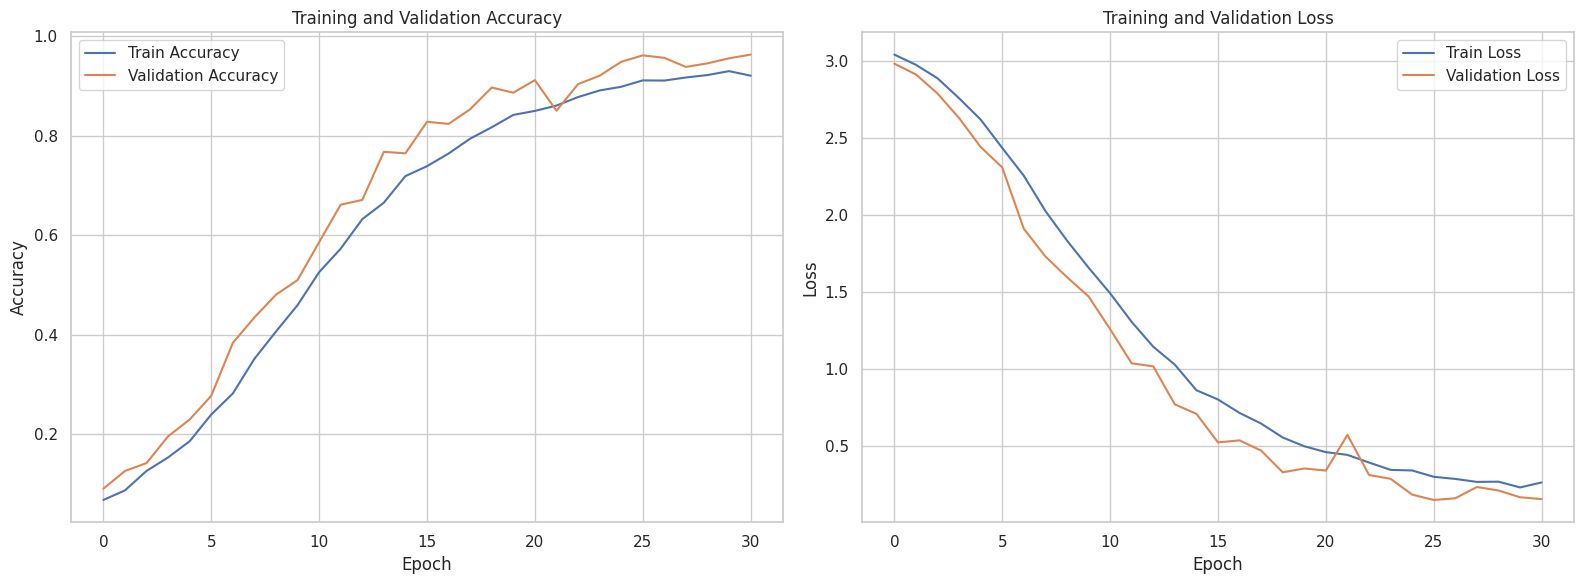

In [20]:
plt.figure(figsize=(16, 6))

# Subplot untuk Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Subplot untuk Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
# Evaluasi akurasi di data test
test_loss, test_accuracy = model.evaluate(test_generator)
# Akurasi terakhir dari training dan validation
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]

print(f"Train Accuracy: {train_accuracy:.3f} = {train_accuracy*100:.0f}%")
print(f"Validation Accuracy: {val_accuracy:.3f} = {val_accuracy*100:.0f}%")
print(f"Test Accuracy: {test_accuracy:.3f} = {test_accuracy*100:.0f}%")


165/165 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.9662 - loss: 0.1317
Train Accuracy: 0.920 = 92%
Validation Accuracy: 0.962 = 96%
Test Accuracy: 0.961 = 96%


In [22]:
y_true = test_generator.classes
y_pred_prob = model.predict(test_generator, verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)

# 5. Classification Report: Precision, Recall, F1-Score
report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)

# Print precision, recall, f1-score secara umum (macro average)
precision = report['macro avg']['precision']
recall = report['macro avg']['recall']
f1_score = report['macro avg']['f1-score']

print(f"Precision (Macro Avg): {precision:.3f} = {precision*100:.0f}%")
print(f"Recall (Macro Avg): {recall:.3f} = {recall*100:.0f}%")
print(f"F1 Score (Macro Avg): {f1_score:.3f} = {f1_score*100:.0f}%")

Precision (Macro Avg): 0.962 = 96%
Recall (Macro Avg): 0.961 = 96%
F1 Score (Macro Avg): 0.961 = 96%


## Konversi Model

In [23]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [24]:
# 2. Import libraries
import tensorflow as tf
import tensorflowjs as tfjs
import os
import pathlib

# 3. Load model dari best_model.h5
model = tf.keras.models.load_model('best_model.h5')

# 4. Membuat folder submission kalau belum ada
os.makedirs('submission/tfjs_model', exist_ok=True)
os.makedirs('submission/tflite', exist_ok=True)
os.makedirs('submission/saved_model', exist_ok=True)

# 5. Convert ke TensorFlow.js
tfjs.converters.save_keras_model(model, 'submission/tfjs_model')

# 6. Convert ke SavedModel (.pb + variables)
tf.saved_model.save(model, 'submission/saved_model')

# 7. Convert ke TFLite
converter = tf.lite.TFLiteConverter.from_saved_model('submission/saved_model')
tflite_model = converter.convert()

# Simpan model.tflite
tflite_model_file = pathlib.Path('submission/tflite/model.tflite')
tflite_model_file.write_bytes(tflite_model)

# 8. Simpan label.txt
# (buat file label.txt sesuai label di train_generator)

# Ambil label dari train_generator
labels = list(train_generator.class_indices.keys())

# Simpan ke label.txt
with open('submission/tflite/label.txt', 'w') as f:
    for label in labels:
        f.write(label + '\n')

print("✅ Semua model sudah berhasil dikonversi!")

failed to lookup keras version from the file,
    this is likely a weight only file
✅ Semua model sudah berhasil dikonversi!


In [25]:
!zip -r /content/submission.zip /content/submission

  adding: content/submission/ (stored 0%)
  adding: content/submission/tflite/ (stored 0%)
  adding: content/submission/tflite/model.tflite (deflated 74%)
  adding: content/submission/tflite/label.txt (deflated 37%)
  adding: content/submission/tfjs_model/ (stored 0%)
  adding: content/submission/tfjs_model/group1-shard1of1.bin (deflated 7%)
  adding: content/submission/tfjs_model/model.json (deflated 86%)
  adding: content/submission/saved_model/ (stored 0%)
  adding: content/submission/saved_model/variables/ (stored 0%)
  adding: content/submission/saved_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/submission/saved_model/variables/variables.index (deflated 55%)
  adding: content/submission/saved_model/saved_model.pb (deflated 85%)
  adding: content/submission/saved_model/assets/ (stored 0%)
  adding: content/submission/saved_model/fingerprint.pb (stored 0%)


In [26]:
!cp /content/submission.zip /content/drive/MyDrive/

## Inference (Optional)

In [29]:
import tensorflow as tf
from keras.layers import TFSMLayer
import numpy as np
from tensorflow.keras.preprocessing import image

# Load model dari SavedModel
model = TFSMLayer('/content/submission/saved_model', call_endpoint='serving_default')

# Load labels
with open('/content/submission/tflite/label.txt', 'r') as f:
    labels = f.read().splitlines()

# Function untuk preprocessing gambar
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Normalisasi
    img_array = np.expand_dims(img_array, axis=0)  # Tambah batch dimension
    return img_array

# Path gambar (dari Google Drive)
img_paths = [
    '/content/drive/MyDrive/abimanyuu.jpg',
    '/content/drive/MyDrive/gatott.jpg',
    '/content/drive/MyDrive/petruk.jpg'
]

# Prediksi semua gambar
for img_path in img_paths:
    img_array = preprocess_image(img_path)
    preds_dict = model(img_array)      # hasilnya dict
    preds = preds_dict['output_0'].numpy()  # ambil tensor dari dict, lalu numpy

    # Top-5 predictions
    top5_indices = preds[0].argsort()[-5:][::-1]
    top5_labels = [(labels[i], preds[0][i] * 100) for i in top5_indices]

    print(f"Prediksi untuk gambar: {img_path}")
    for label, prob in top5_labels:
        print(f"- {label}: {prob:.2f}%")
    print()


Prediksi untuk gambar: /content/drive/MyDrive/abimanyuu.jpg
- abimanyu: 99.79%
- bagong: 0.16%
- durna: 0.03%
- semar: 0.01%
- bima: 0.00%

Prediksi untuk gambar: /content/drive/MyDrive/gatott.jpg
- gatotkaca: 65.30%
- bima: 13.44%
- abimanyu: 8.92%
- karna: 5.67%
- bagong: 2.25%

Prediksi untuk gambar: /content/drive/MyDrive/petruk.jpg
- petruk: 99.45%
- gareng: 0.52%
- bima: 0.03%
- gatotkaca: 0.00%
- bagong: 0.00%

